In [32]:
!pip install graphframes

In [33]:
# import all tools
#sc.addPyFile('/home/yunlong/spark-3.3.1-bin-hadoop2/jars/graphframes-0.8.2-spark3.0-s_2.12.jar')
import numpy as np
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations
import unittest
from pyspark.sql import types as T, SparkSession
from scipy.spatial import distance
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import numpy as np
from pyspark.sql import Row
import matplotlib.pyplot as plt

In [34]:
import pyspark.sql.functions as F

In [35]:
building_file = "Buildings.csv"
build_df = spark.read.csv(building_file, header=True)

build_df.printSchema()

AnalysisException: Path does not exist: file:/Users/tianjiaohe/BigDataCompute/Buildings.csv

In [5]:
build_df.count()

1042

# DBScan

In [6]:
def __distance_from_pivot(pivot, dist, epsilon, operations):
    """
    Creates a distance function that computes the distance between a given data point and the pivot point.
    
    :param pivot: The pivot point used to compute distances
    :param dist: The distance function to calculate distances between points
    :param epsilon: The distance threshold for clustering
    :param operations: The accumulator for tracking the number of distance computations
    :return: A distance function that takes a data point as input and returns the partition indices and distances
    """
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add(1)
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    """
    Creates a scan function that finds neighboring data points within epsilon distance.
    
    :param epsilon: The distance threshold for clustering
    :param dist: The distance function to calculate distances between points
    :param operations: The accumulator for tracking the number of distance computations
    :return: A scan function that takes a tuple (partition index, list of data points) as input and returns a dictionary of neighboring points
    """
    def scan(x):
        # out dictionary would have point id as key and a set of point ids who are within epsilon distance to
        # key point id. value is basically its neighbors
        out = {}
        # 0th index of x is partition_index
        # 1st index of x is data points
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add(1)
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # both i and j are within epsilon distance to each other
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # returns point and its neighbor as tuple
        return [Row(item[0], item[1]) for item in out.items()]

    return scan


def __label(min_pts):
    """
    Creates a label function that labels the points as core points or non-core points based on the number of neighbors.
    
    :param min_pts: The minimum number of neighbors required for a point to be considered a core point
    :return: A label function that takes a tuple (point id, set of neighboring point ids) as input and returns a list of tuples with point ids and cluster labels
    """
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            # use id as cluster label
            cluster_label = x[0]
            # return True for core point
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                # return False for base point
                out.append((idx, [(cluster_label, False)]))
            return out
        return []

    return label


def __combine_labels(x):
    """
    Combines the cluster labels for each point.
    
    :param x: A tuple (point id, list of (cluster label, core point indicator) tuples)
    :return: A tuple (point id, list of cluster labels, core point indicator)
    """
    # 0th element is the id of point
    # 1st element is the list of tuples with cluster and core point label
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # if core point keep all cluster otherwise only one
    return point, clusters if core_point is True else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    """
    Process given dataframe with DBSCAN parameters
    :param spark: spark session
    :param df: input data frame where each row has id and value keys
    :param epsilon: DBSCAN parameter for distance
    :param min_pts: DBSCAN parameter for minimum points to define core point
    :param dist: method to calculate distance. Only distance metric is supported.
    :param dim: number of dimension of input data
    :param checkpoint_dir: checkpoint path as required by Graphframe
    :param operations: class for managing accumulator to calculate number of distance operations
    :return: A dataframe of point id, cluster component and boolean indicator for core point
    """
    zero = df.rdd.takeSample(False, 1)[0].value
    combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()
    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
    #print(combine_cluster_rdd.collect())
    #print('the number of operations:',operations.value)
    try:
    #for i in range(1):
    #while(0):
        id_cluster_df = id_cluster_rdd.toDF()
        vertices = combine_cluster_rdd.\
            flatMap(lambda x: [Row(id=item) for item in x[1]]).toDF().distinct()
        edges = combine_cluster_rdd. \
            flatMap(lambda x: [Row(src=item[0], dst=item[1])
                               for item in combinations(x[1], 2)]). \
            toDF().distinct()
        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        g = GraphFrame(vertices, edges)
        connected_df = g.connectedComponents()
        id_cluster_df = id_cluster_df.\
            join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")
        return id_cluster_df
    except ValueError:
        return None
    
def ReaddataToDF(filename):
    """
    Reads data from a file and converts it into a DataFrame.
    
    :param filename: The name of the file containing the data
    :return: A DataFrame with columns "id" and "value"
    """
    data = spark.read.text(filename).rdd.map(lambda r: r[0].split(',')).zipWithIndex().map(lambda r: Row(id=r[1],value=(float(r[0][0]),float(r[0][1]))))
    schema = T.StructType([
    T.StructField("id", T.IntegerType(), False),
    T.StructField("value", T.ArrayType(T.FloatType()), False)
    ])
    df = spark.createDataFrame(data, schema)
    return df

def dist(x, y):
    """
    Calculates the Euclidean distance between two points.
    
    :param x: The first point
    :param y: The second point
    :return: The Euclidean distance between x and y
    """
    return distance.euclidean(x, y)

# retrieve the coordinates

In [13]:
!pip install shapely
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 8.4 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 7.4 MB/s eta 0:00:0000:0100:01m


In [14]:
import pandas as pd

In [15]:
from shapely import wkt
import geopandas as gpd

# df is as PySpark dataframe

# Covert it to Pandas dataframe
pd_df = build_df.toPandas()
#pd_df['location']=b['point_wkt'].apply(wkt.loads)
pd_df['geometry']=pd_df['location'].apply(wkt.loads)
#pd_df['geometry']=pd['point_wkt'].apply(wkt.loads)

# Convert it to GeoPandas dataframe
gdf  = gpd.GeoDataFrame(pd_df, geometry='geometry')

In [19]:
btype=pd_df.buildingType

In [20]:
a=[i.exterior.coords.xy for i in gdf.geometry]

In [21]:
bu=np.array([(np.mean(i[0]),np.mean(i[1])) for i in a])

# split the data according to its type

In [22]:
c_ind=np.where(btype=='Commercial')[0]

In [23]:
r_ind=np.where(btype=='Residental')[0]

In [24]:
s_ind=np.where(btype=='School')[0]

# plot the original data

In [25]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 150

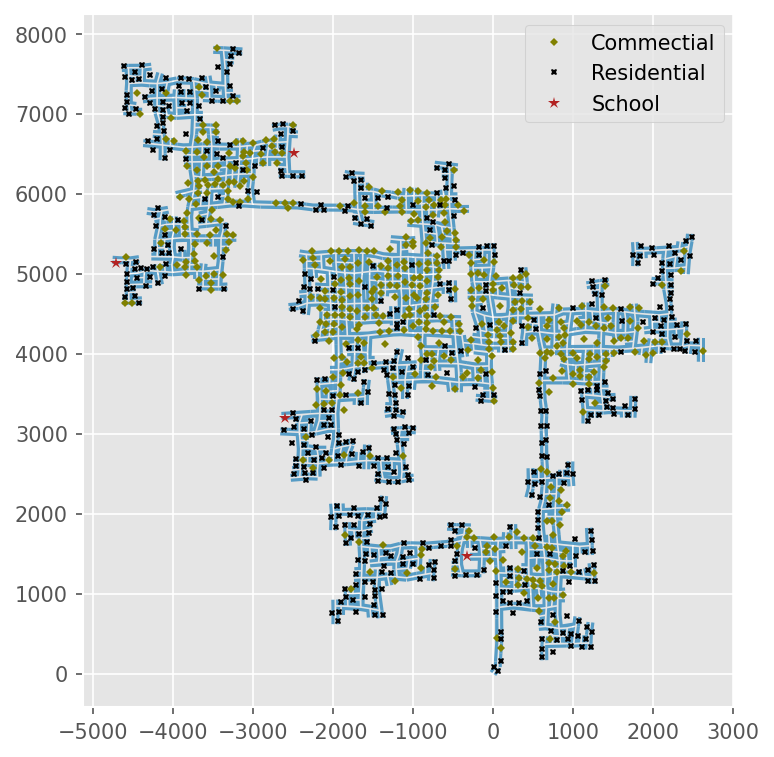

In [27]:
gdf.geometry.plot(alpha=0.8)
plt.plot(bu[c_ind, 0], bu[c_ind, 1], 'D', markerfacecolor='olive',label='Commectial',
             markeredgewidth=0.0,markersize=3, scalex=1, scaley=1)
plt.plot(bu[r_ind, 0], bu[r_ind, 1], 'X', markerfacecolor='black',label='Residential',
             markeredgewidth=0.0, markersize=3, scalex=1, scaley=1)
plt.plot(bu[s_ind, 0], bu[s_ind, 1], '*', markerfacecolor='firebrick',label='School',
             markeredgewidth=0.0, markersize=6, scalex=1, scaley=1)

plt.legend(loc="best")
plt.savefig('original_building.png')

# plot the DBScan result

In [28]:
# Test3 algorithm on circle

# Define the schema
schema = T.StructType([
    T.StructField("id", T.IntegerType(), False),
    T.StructField("value", T.ArrayType(T.FloatType()), False)
])

# Convert the data to the desired format
build_data = [(ind, [float(x),float(y)]) for ind, (x,y) in enumerate(bu)]

# Create a DataFrame
df_build = spark.createDataFrame(build_data, schema=schema)


In [29]:
# commertial
#fit DBScan
c_clusters = process(spark, df_build.where(F.col('id').isin(c_ind.tolist())), 200, 5, dist, 2, "checkpoint")
c_out = c_clusters.distinct().select('point','component')

# data_row was used to plot
c_rows  = c_out.select(c_out.point.alias('id'),c_out.component.alias('label')).join(df_build.where(F.col('id').isin(c_ind.tolist())),'id').collect()

# Convert the Row objects to dictionaries
c_dicts = [row.asDict() for row in c_rows]


/Users/tianjiaohe/spark/spark-3.3.1-bin-hadoop2/python/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/Users/tianjiaohe/spark/spark-3.3.1-bin-hadoop2/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [30]:
# residential
#fit DBScan
r_clusters = process(spark, df_build.where(F.col('id').isin(r_ind.tolist())), 200, 5, dist, 2, "checkpoint")
r_out = r_clusters.distinct().select('point','component')

# data_row was used to plot
r_rows  = r_out.select(r_out.point.alias('id'),r_out.component.alias('label')).join(df_build.where(F.col('id').isin(r_ind.tolist())),'id').collect()

#show result
#print(databuild_rows)
# Plot Test3 result
# Convert the Row objects to dictionaries
r_dicts = [row.asDict() for row in r_rows]

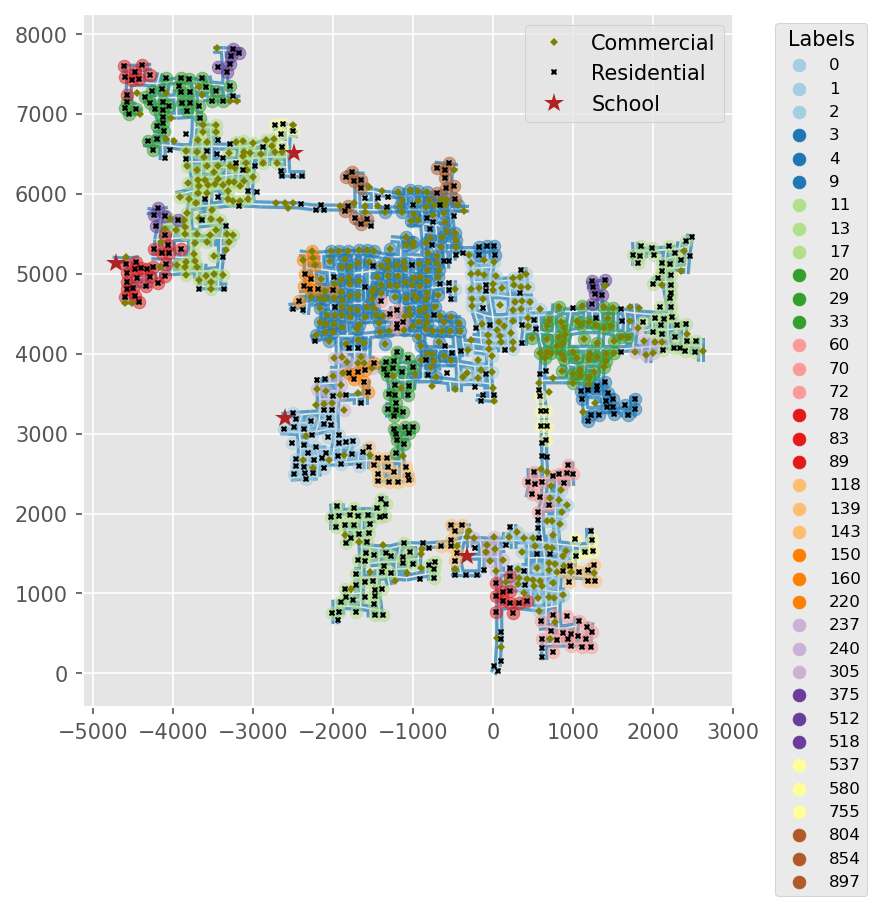

In [31]:
gdf.geometry.plot(alpha=0.8)
plt.plot(bu[c_ind, 0], bu[c_ind, 1], 'D', markerfacecolor='olive',label='Commercial',
             markeredgewidth=0.0, markersize=3, scalex=1, scaley=1)
plt.plot(bu[r_ind, 0], bu[r_ind, 1], 'X', markerfacecolor='black',label='Residential',
             markeredgewidth=0.0, markersize=3, scalex=1, scaley=1)
plt.plot(bu[s_ind, 0], bu[s_ind, 1], '*', markerfacecolor='firebrick',label='School',
             markeredgewidth=0.0, markersize=10, scalex=1, scaley=1)

#handles, labels = plt.gca().get_legend_handles_labels()
first_legend = plt.legend(loc='upper right')

plt.gca().add_artist(first_legend)

clusterlabel = sorted(set([d["label"] for d in c_dicts+r_dicts]))
# Create a colormap for labels
cmap = plt.cm.get_cmap("Paired", len(clusterlabel))


# Plot the points with different colors based on their label
for d in c_dicts+r_dicts:
    plt.scatter(
        d["value"][0], d["value"][1], color=[cmap(clusterlabel.index(d["label"]) / len(clusterlabel))],alpha=0.5
    )

#plt.legend(loc="best")

handles =[plt.scatter([], [], color=cmap(i / len(clusterlabel))) for i in range(len(clusterlabel))]
plt.legend(handles, clusterlabel, title="Labels", loc="best", fontsize=8,bbox_to_anchor=(1.05, 1))
plt.savefig('result.png')